In [1]:
import glob

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split

from src.classes import Boundary, TankProperties32x2, BallAnomaly
from src.performance_evaluation import (
    center_of_mass,
    compute_position_error,
    compute_volume_error,
    compute_voxel_error,
)
from src.util import voxel_ball, plot_voxel_c
import os
from src.betaVAE_model import vae_model
import pandas as pd
import seaborn as sns
from tensorflow.keras.optimizers import SGD, Adam
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

boundary = Boundary()

2025-01-20 08:59:14.742719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737363554.853680 3042259 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737363554.886145 3042259 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 08:59:15.416087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


W0000 00:00:1737363574.422380 3042259 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


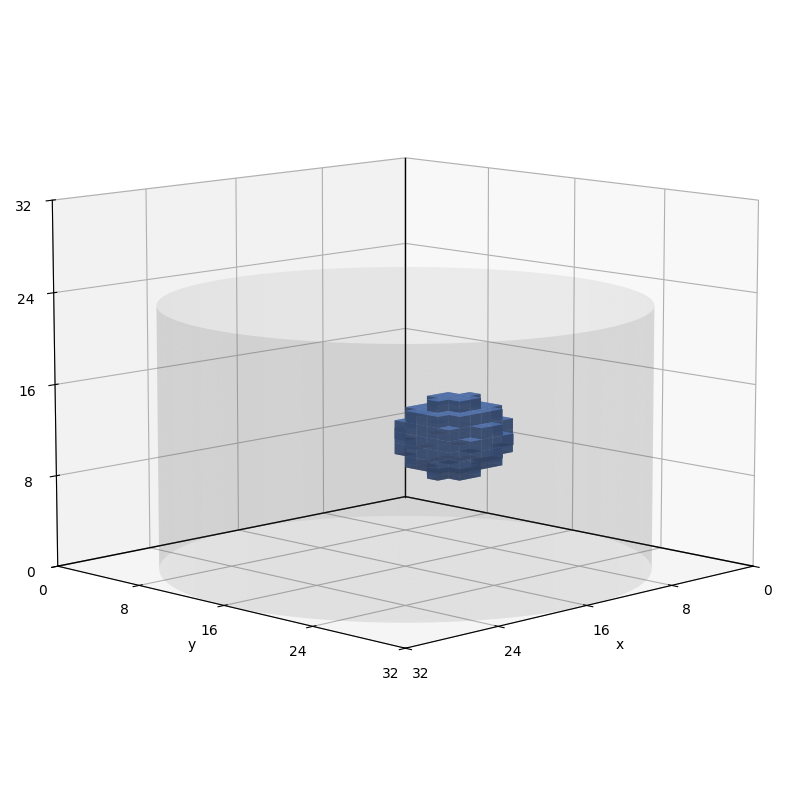

In [2]:
def voxel_ball(ball, boundary, empty_gnd=0, mask=False):
    
    scale_factor = 32 / 194  # 32 voxels / 194mm (tank diameter)
    ball_diameter_voxels = round(ball.d * scale_factor)
    #print(f"ball_diameter_voxels: {ball_diameter_voxels}")
    
    y, x, z = np.indices((boundary.x_length, boundary.y_length, boundary.z_length))
    voxel = (
        np.sqrt((x - ball.x) ** 2 + (y - ball.y) ** 2 + (z - ball.z) ** 2) < ball_diameter_voxels / 2
    )
    if mask:
        return voxel
    else:
        return np.where(voxel, ball.perm, empty_gnd)

def create_cylinder_mesh(radius, height, n_points=100):
    theta = np.linspace(0, 2*np.pi, n_points)
    z = np.linspace(0, height, n_points)
    theta, z = np.meshgrid(theta, z)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y, z

def plot_tank_and_ball(ball: BallAnomaly, tank: TankProperties32x2, boundary: Boundary):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
   
    scale_factor = 32 / tank.T_d 
    
    cylinder_radius = tank.T_r * scale_factor
    cylinder_height = tank.T_bz[1] * scale_factor
    x_cyl, y_cyl, z_cyl = create_cylinder_mesh(cylinder_radius, cylinder_height)
    
    x_cyl += 16  
    y_cyl += 16  
    
    ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
    
    ball_voxels = voxel_ball(ball, boundary)
    
    ax.voxels(ball_voxels.transpose(1, 0, 2), facecolors='cornflowerblue', alpha=0.8)
    
    ax.plot([0, boundary.x_length], [0, 0], [0, 0], 'k-', linewidth=1)
    #ax.text(boundary.x_length+1, 0, 0, 'x')
    
    ax.plot([0, 0], [0, boundary.y_length], [0, 0], 'k-', linewidth=1)
    #ax.text(0, boundary.y_length+1, 0, 'y')
    
    ax.plot([0, 0], [0, 0], [0, boundary.z_length], 'k-', linewidth=1)
    #ax.text(0, 0, boundary.z_length+1, 'z')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_xlim([boundary.x_0, boundary.x_length])
    ax.set_ylim([boundary.y_0, boundary.y_length])
    ax.set_zlim([boundary.z_0, boundary.z_length])
    
    # Set grid with minor lines
    ax.grid(True)
    
    # Set major ticks to show 0,8,16,24,32
    ax.set_xticks([0, 8, 16, 24, 32])
    ax.set_yticks([0, 8, 16, 24, 32])
    ax.set_zticks([0, 8, 16, 24, 32])
    
    # Set view angle
    ax.view_init(elev=10, azim=45)
    
    plt.tight_layout()
    plt.show()

# Create instances
tank = TankProperties32x2()
ball = BallAnomaly(x=10.5, y=15, z=10, d=40, perm=1)
boundary = Boundary()

# Generate plot
plot_tank_and_ball(ball, tank, boundary)

In [3]:
ball = BallAnomaly(x=10.5, y=10, z=10, d=38, perm=1)

In [4]:
ball_vxl = voxel_ball(ball, boundary)

In [5]:
#plot_voxel(ball_vxl)

In [6]:
gamma = list()
diameter_labels = list()
pos_ball = list()
vol_ball = list()
perm = 1
d = 40
scale_factor = 32 / 194  # Umrechnungsfaktor von mm in Voxel

d_voxels = round(d * scale_factor)

for x in np.linspace(boundary.x_0 + d_voxels, boundary.x_length - d_voxels, 20):
    for y in np.linspace(boundary.y_0 + d_voxels, boundary.y_length - d_voxels, 20):
        for z in np.linspace(
            boundary.z_0 + d_voxels, boundary.z_length - d_voxels, 20
        ):
            ball = BallAnomaly(x, y, z, d, perm)  # d bleibt in mm für BallAnomaly
            vxl_ball = voxel_ball(ball, boundary)
            gamma.append(vxl_ball)
            diameter_labels.append(d)  # Original-Durchmesser in mm
            pos_ball.append([ball.y, ball.x, ball.z])
            vol_ball.append(np.where(vxl_ball == 1)[0].shape[0])

gamma = np.array(gamma) / 2
diameter_labels = np.array(diameter_labels)
pos_ball = np.array(pos_ball)
vol_ball = np.array(vol_ball)


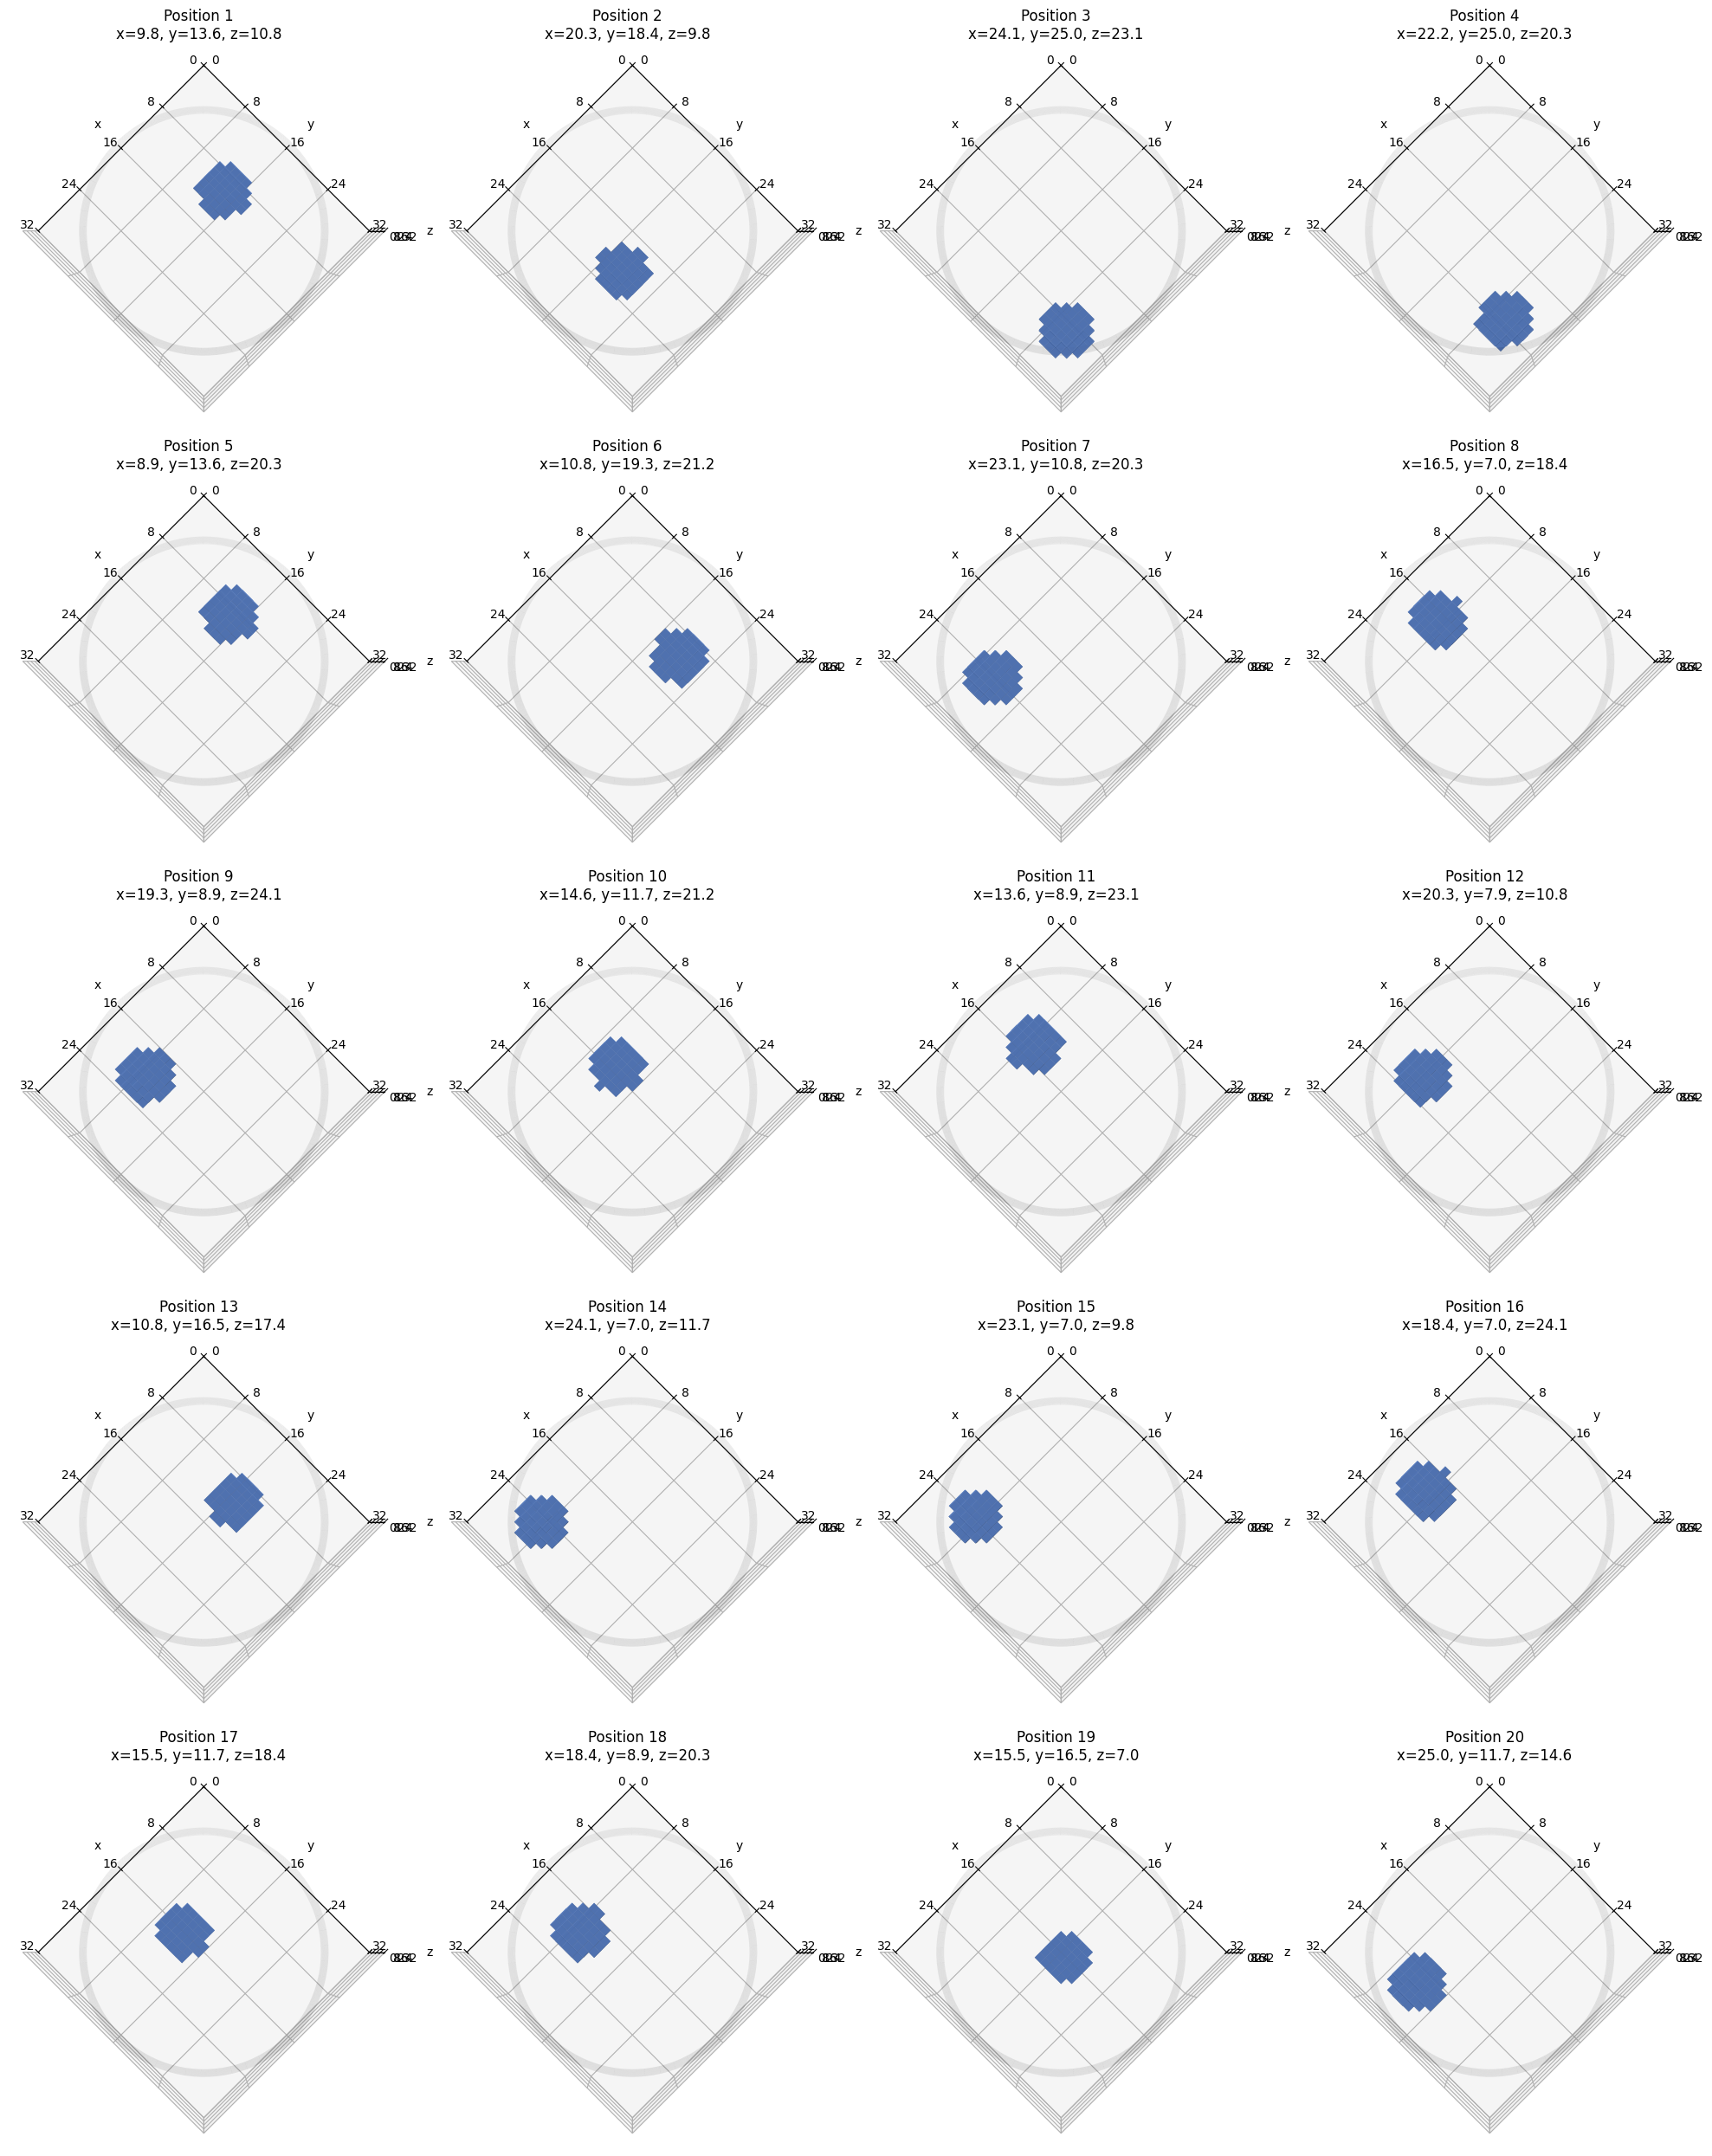

In [7]:
def plot_multiple_positions(pos_ball, n_positions=20, ball_diameter = ball.d):
    """
    Plot ball positions in a 5x4 subplot grid using existing functions
    
    Args:
        pos_ball: Array of positions [y, x, z]
        n_positions: Number of positions to plot (default: 20)
        ball_diameter: Diameter of the ball in mm (default: 38)
    """
    tank = TankProperties32x2()
    boundary = Boundary()
    perm = 1
    
    # Create figure for subplots
    fig = plt.figure(figsize=(20, 25))
    
    # Randomly select n_positions from pos_ball
    selected_indices = np.random.choice(len(pos_ball), n_positions, replace=False)
    
    # Plot selected positions
    for i, idx in enumerate(selected_indices):
        # Get position (note: pos_ball is [y, x, z])
        y, x, z = pos_ball[idx]
        
        # Create ball instance
        ball = BallAnomaly(x=x, y=y, z=z, d=ball_diameter, perm=perm)
        
        # Create subplot
        ax = fig.add_subplot(5, 4, i+1, projection='3d')
        
        # Use existing functions to plot tank and ball
        scale_factor = 32 / tank.T_d 
        cylinder_radius = tank.T_r * scale_factor
        cylinder_height = tank.T_bz[1] * scale_factor
        x_cyl, y_cyl, z_cyl = create_cylinder_mesh(cylinder_radius, cylinder_height)
        
        x_cyl += 16
        y_cyl += 16
        
        ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
        ball_voxels = voxel_ball(ball, boundary)
        ax.voxels(ball_voxels.transpose(1, 0, 2), facecolors='cornflowerblue', alpha=0.8)
        
        # Set axis properties
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        
        ax.set_xlim([boundary.x_0, boundary.x_length])
        ax.set_ylim([boundary.y_0, boundary.y_length])
        ax.set_zlim([boundary.z_0, boundary.z_length])
        
        ax.grid(True)
        ax.set_xticks([0, 8, 16, 24, 32])
        ax.set_yticks([0, 8, 16, 24, 32])
        ax.set_zticks([0, 8, 16, 24, 32])
        
        ax.view_init(elev=90, azim=45)
        
        # Add position information
        ax.set_title(f'Position {i+1}\nx={x:.1f}, y={y:.1f}, z={z:.1f}')
    
    plt.tight_layout()
    plt.show()

plot_multiple_positions(pos_ball)

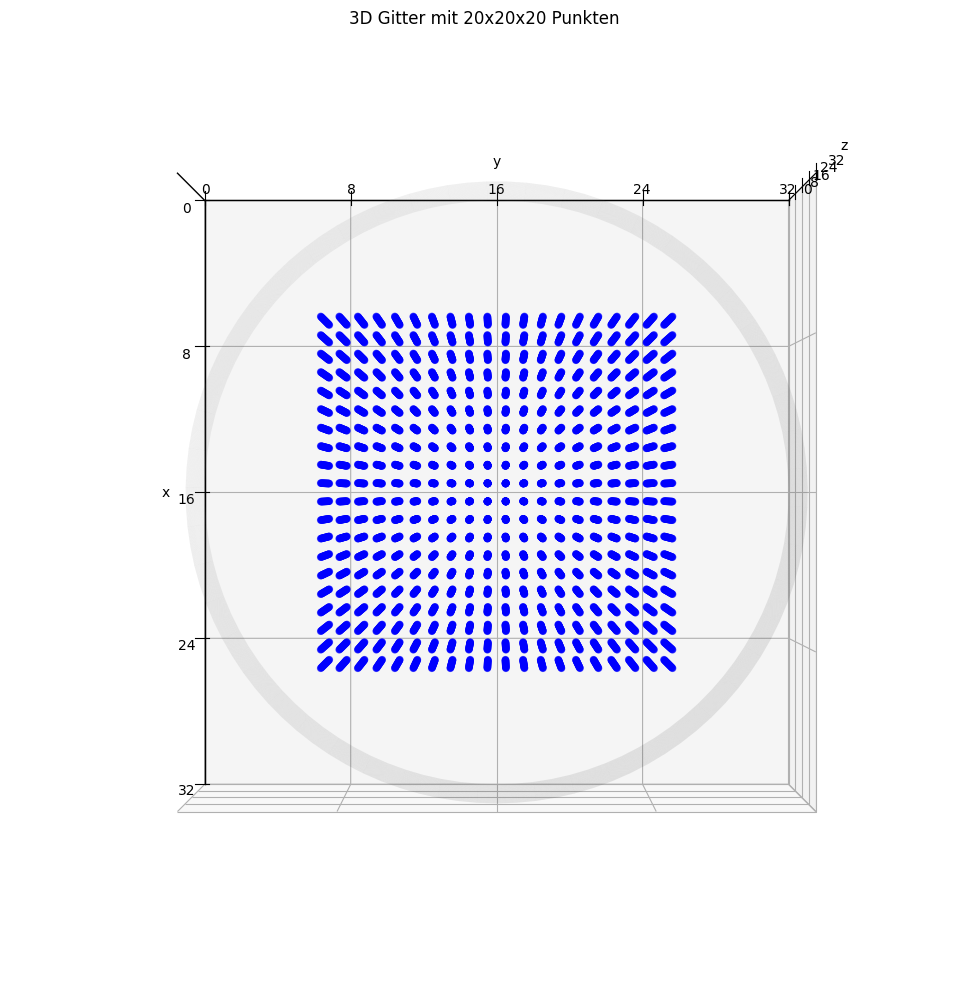

In [8]:

def visualize_grid_points(boundary, d_voxels, tank, num_points=20):
    """
    Visualisiert die Gitterpunkte im 3D-Raum mit Tank
    
    Parameters:
    -----------
    boundary : object
        Objekt mit x_0, y_0, z_0, x_length, y_length, z_length Attributen
    d_voxels : float
        Einrückung von den Rändern in Voxeln
    tank : TankProperties32x2
        Tank-Objekt mit Eigenschaften
    num_points : int, optional
        Anzahl der Punkte pro Dimension (default: 20)
    """
    # Erstelle die Gitterpunkte
    x = np.linspace(boundary.x_0 + d_voxels, boundary.x_length - d_voxels, num_points)
    y = np.linspace(boundary.y_0 + d_voxels, boundary.y_length - d_voxels, num_points)
    z = np.linspace(boundary.z_0 + d_voxels, boundary.z_length - d_voxels, num_points)
    
    # Erstelle das Gitter
    X, Y, Z = np.meshgrid(x, y, z)
    
    # Erstelle die Figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotte den Tank
    scale_factor = 32 / tank.T_d
    cylinder_radius = tank.T_r * scale_factor
    cylinder_height = tank.T_bz[1] * scale_factor
    x_cyl, y_cyl, z_cyl = create_cylinder_mesh(cylinder_radius, cylinder_height)
    
    # Verschiebe den Zylinder zur Mitte
    x_cyl += 16
    y_cyl += 16
    
    # Plotte den Tank
    ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
    
    # Plotte die Gitterpunkte
    scatter = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), 
                        c='blue', alpha=0.6, s=20)
    
    # Beschrifte die Achsen
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Setze den Titel
    ax.set_title(f'3D Gitter mit {num_points}x{num_points}x{num_points} Punkten')
    
    # Setze die Achsengrenzen
    ax.set_xlim([boundary.x_0, boundary.x_length])
    ax.set_ylim([boundary.y_0, boundary.y_length])
    ax.set_zlim([boundary.z_0, boundary.z_length])
    
    # Setze die Ticks
    ax.set_xticks([0, 8, 16, 24, 32])
    ax.set_yticks([0, 8, 16, 24, 32])
    ax.set_zticks([0, 8, 16, 24, 32])
    
    # Zeige das Grid
    ax.grid(True)
    
    # Setze den Blickwinkel
    ax.view_init(elev=90, azim=0)
    
    # Zeichne die Koordinatenachsen
    ax.plot([0, boundary.x_length], [0, 0], [0, 0], 'k-', linewidth=1)
    ax.plot([0, 0], [0, boundary.y_length], [0, 0], 'k-', linewidth=1)
    ax.plot([0, 0], [0, 0], [0, boundary.z_length], 'k-', linewidth=1)
    
    plt.tight_layout()
    
    return fig, ax


tank = TankProperties32x2()
fig, ax = visualize_grid_points(boundary, d_voxels, tank)
plt.show()


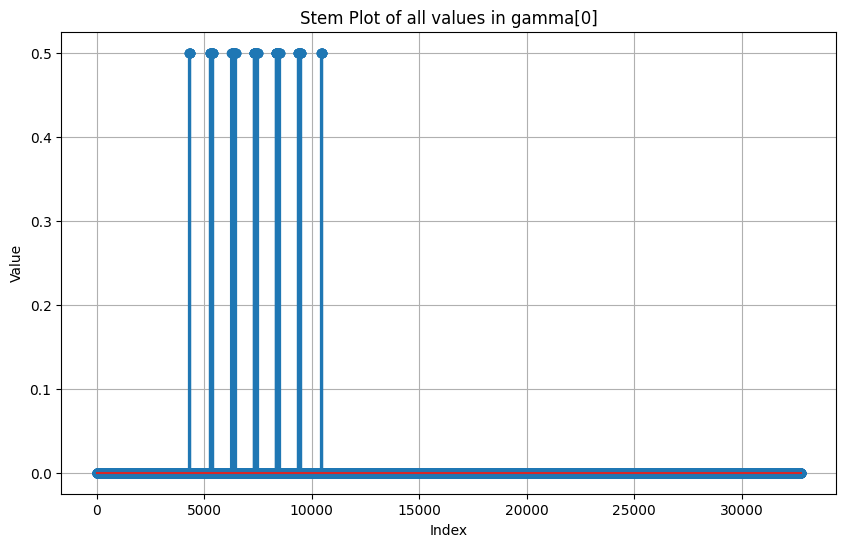

In [9]:
plt.figure(figsize=(10, 6))
x = range(32*32*32)
plt.stem(x, gamma[0].flatten())
plt.grid(True)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Stem Plot of all values in gamma[0]')
plt.show()

In [10]:
print(gamma.shape, diameter_labels.shape)

(8000, 32, 32, 32) (8000,)


In [11]:
(
    gamma_train,
    gamma_test,
    r_train,
    r_test,
    pos_train,
    pos_test,
    vol_train,
    vol_test,
) = train_test_split(
    gamma,
    diameter_labels,
    pos_ball,
    vol_ball,
    train_size=0.9,
    shuffle=True,
    random_state=42,
)

In [12]:
print(
    gamma_train.shape,
    gamma_test.shape,
    r_train.shape,
    r_test.shape,
    pos_train.shape,
    pos_test.shape,
    vol_train.shape,
    vol_test.shape,
)

(7200, 32, 32, 32) (800, 32, 32, 32) (7200,) (800,) (7200, 3) (800, 3) (7200,) (800,)


In [13]:
#for rdn in np.random.randint(low=0, high=X_train.shape[0], size=5):
    #print(rdn)
    #print("Pos:\t", pos_train[rdn])
    #print("Vol:\t", vol_train[rdn])
    #plot_voxel_c(X_train[rdn, ...] * 2)

In [14]:
#decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")
vae = vae_model()
input_shape=(32, 32, 32, 1)  # Form der Eingabedaten ohne Batch-Dimension
vae.build(input_shape=(None, *input_shape))
print(f"Modell gebaut: {vae.built}")
vae.encoder.summary()
vae.decoder.summary()

Modell gebaut: True


Model: "VAE_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │          4 │ input_layer_2[0]… │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │         28 │ batch_normalizat… │
│                     │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │          4 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 16, 16,    │         56 │ batch_normalizat… │
│                     │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │          8 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 8, 8, 8,   │        220 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │         16 │ conv3d_6[0][0]    │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 4, 4, 4,   │        872 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 4,   │         32 │ conv3d_7[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      4,104 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      4,104 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,448 (36.91 KB)

 Trainable params: 9,416 (36.78 KB)

 Non-trainable params: 32 (128.00 B)

Model: "VAE_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 4, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_4              │ (None, 8, 8, 8, 8)     │         1,736 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 8, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_5              │ (None, 16, 16, 16, 4)  │           868 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 16, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_6              │ (None, 32, 32, 32, 2)  │           218 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32, 2)  │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_7              │ (None, 32, 32, 32, 1)  │            55 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32, 1)  │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,545 (29.47 KB)

 Trainable params: 7,515 (29.36 KB)

 Non-trainable params: 30 (120.00 B)

In [15]:
epochs = 200
batch_size = 8
beta = 0.98

#cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=47)

vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.compile(optimizer=Adam())  # learning_rate = learning_rate



In [ ]:
history = vae.fit(
    np.expand_dims(gamma_train, 4),
    epochs=epochs,
    batch_size=batch_size,
    #callbacks=[cb],
)

Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - kl_loss: 8.7303 - loss: 663.5416 - reconstruction_loss: 654.9854 - total_loss: 663.5416
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 78s 87ms/step - kl_loss: 4.5320 - loss: 604.4249 - reconstruction_loss: 599.9832 - total_loss: 604.4249
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - kl_loss: 3.8701 - loss: 552.0814 - reconstruction_loss: 548.2888 - total_loss: 552.0814
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - kl_loss: 3.5962 - loss: 548.0273 - reconstruction_loss: 544.5032 - total_loss: 548.0273
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - kl_loss: 2.5074 - loss: 539.3510 - reconstruction_loss: 536.8940 - total_loss: 539.3510
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - kl_loss: 2.1533 - loss: 530.9210 - reconstruction_loss: 528.8107 - total_loss: 530.9210
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - kl_loss: 2.1353 - loss: 531.4565 - reconstruction_loss: 529.3640 - total_

In [ ]:
fpath = 'Abbildungen/'  # Pfad anpassen
fname = 'loss_curve_3Dvae'

plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

plt.savefig(f'{fpath}{fname}.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
vae = vae_model()  # Erstelle die gleiche Modellinstanz
vae.build(input_shape=(32, 32, 32, 1))  # Baue das Modell mit der passenden Eingabeform
vae_idx = len(glob.glob("weights/3Dvae*.h5")) + 1
vae.save_weights(f"weights/3Dvae_{vae_idx}.weights.h5")

In [ ]:
vae = vae_model()  # Erstelle die gleiche Modellinstanz
vae.build(input_shape=(32, 32, 32, 1))  # Baue das Modell mit der passenden Eingabeform
vae.load_weights("weights/3Dvae_4.weights.h5")
print("Gewichte erfolgreich geladen.")

In [ ]:
from src.util import plot_voxel_c

In [ ]:
plt.style.use("default")
for rdn in np.random.randint(low=0, high=gamma_test.shape[0], size=5):
    print("Original...")
    plot_voxel_c(gamma_test[rdn, ...])

    print("Prediction...")
    _, _, z = vae.encoder.predict(np.expand_dims(gamma_test[rdn, ...], 0))
    sgl_pred = vae.decoder.predict(z)
    sgl_pred = np.squeeze(sgl_pred, axis=4)
    sgl_pred = np.squeeze(sgl_pred, axis=0)
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    plot_voxel_c(sgl_pred)

In [ ]:
sgl_pred.shape

In [ ]:
acc_measure_df = pd.DataFrame(acc_measure).dropna()
#acc_measure_df.to_csv(f"models/vaes/vae_acc_measure_{vae_idx}.csv", index=False)
acc_measure_df

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

sns.boxplot(
    x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=False
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")